<a href="https://colab.research.google.com/github/DuncanJWood/BiX/blob/main/Exercise3_cbgt_and_pred_prey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exercise 3: CBGT networks and predator-prey dynamics**

## Getting started

This homework will involve concepts from the labs we've gone over in class. Feel free to reference them as you complete the assignment.

This homework contains 2 sections:
1. Simulating decisions in the CBGT network uner stronger direct vs indirect pathway gain.
1. Simulating predator-prey dynamics under varying prey behavior when the predator moves actively towards the prey.

Fill out the code cells below and answer the questions to complete the assignment. Most of the programming is quite straightforward, as it is all based on code from the labs, which you can use/modify in this notebook.


---
## Part 1 - CBGT decision simulations [51 pt]

Here you will be adapting the Lab 5 code so that you increase the indirect *and* direct pathways gains by 33% (we did 10% in class). This will give a clearer visualization of how these two pathways control the overall reaction times when you plot their joint histogram.


In the code cells below, fill in (and run) code according to the text instructions before each one. Refer to lab 5 for help.

#### Change Colab's working directory to the `/content` folder using the `cd` command

In [1]:
cd /content

/content


#### Clone in the CBGT library from https://github.com/CoAxLab/CBGT

In [2]:
!git clone https://github.com/CoAxLab/CBGT

Cloning into 'CBGT'...
remote: Enumerating objects: 604, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 604 (delta 10), reused 5 (delta 0), pack-reused 581
Receiving objects: 100% (604/604), 13.84 MiB | 30.35 MiB/s, done.
Resolving deltas: 100% (322/322), done.


#### Change Colab's working directory to the `/content/CBGT` folder

In [3]:
cd /content/CBGT

/content/CBGT


#### Import the necessary modules

In [4]:
# import libraries and configure plots

import os, sys
import pandas as pd
import numpy as np
import random
from future.utils import listvalues
from copy import deepcopy

import cbgt.netgen as ng
import cbgt.analyzefx as afx
from cbgt import vis, sim

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter('ignore', np.RankWarning)
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore")

%matplotlib inline
clrs = ['#347fff', '#febe08']
eclrs = ['#1657de', '#f5a005']

rc = {'lines.solid_capstyle': u'butt'}
sns.set(style='ticks', rc=rc, font_scale=1.4)

#### Specify the saving directory and set default model parameters/weights exactly as we did in the CBGT lab.

In [6]:
# specify saving directory

parentDir = 'cbgtDemoTEST'
savedir = os.path.join(os.path.expanduser('~'), parentDir)
if not os.path.isdir(savedir):
    os.mkdir(savedir)

# specify certain model parameters

BaseStim = 0
Stim = 2.54
Dynamic = 30.0
Choices = 2
rampingCTX = True
popscale = .3
Start=200

# save dMSN/iMSN weight presets for each choice

presetLow = ng.set_post_learning_weights(dMSN=[1.01, 0.99], iMSN=[1.0,1.0])
presetHi = ng.set_post_learning_weights(dMSN=[1.03, 0.98], iMSN=[1.0,1.0])
presets = [presetLow, presetHi]

conds = ['low', 'high']
condABC = ['a', 'b']
cond12 = [1, 2]

savedirs = [os.path.join(savedir, c) for c in conds]
saveLow, saveHi = savedirs
saveTest=os.path.join(savedir, 'test')

presetDict = dict(zip(conds, presets))
condOrder = dict(zip(conds, condABC))
condLevel = dict(zip(conds+['test'], cond12+[0]))

#### Define the helping functions for getting sampling parameters, sampling region activations, and building a single network.

In [52]:
# helper functions to specify connection efficiacies for certain pathways

def get_sampling_params(scale, direct_strength, indirect_strength):

    # set strengths of background inputs/currents
    CxSTR      =    0.2
    CxTh       =    0.03
    CxFSI      =    0.165
    D1STR_GPi  =    direct_strength * 1.10
    D2STR_GPeP =    indirect_strength * 1.65
    STN_GPeP_A =    0.07
    STN_GPeP_N =    4.01
    STN_GPi    =    0.04 # 0.0324
    GPi_Th     =    0.067
    ThSTR      =    0.34
    ThCx       =    0.02

    mu = dict(Cx={'STR':CxSTR, 'Th':CxTh, 'FSI':CxFSI},
                Th={'STR':ThSTR, 'Cx':ThCx},
                D1STR={'GPi': D1STR_GPi},
                D2STR={'GPeP': D2STR_GPeP},
                STN={'GPi': STN_GPi},
                GPi={'Th': GPi_Th})
    sd = {i:{j: mu[i][j]*scale for j in list(mu[i])} for i in list(mu)}
    return mu, sd

# assign the background inputs to each brain region accordingly
def sample_network_efficacies(muEff, sdEff, N):
    X = {}
    nuclei = list(muEff)
    for i in nuclei:
        targets = list(muEff[i])
        X[i] = {}
        for j in targets:
            X[i][j] = np.random.normal(muEff[i][j], sdEff[i][j], N)
    return X

# build the network with specified connections
def build_single_network(X, idx=0):

    Cx={'STR': X['Cx']['STR'][idx],
        'Th': X['Cx']['Th'][idx],
        'FSI': X['Cx']['FSI'][idx]}

    D1STR={'GPi': X['D1STR']['GPi'][idx]}
    D2STR={'GPeP': X['D2STR']['GPeP'][idx]}

    STN={'GPi': X['STN']['GPi'][idx]}

    GPi={'Th': X['GPi']['Th'][idx]}

    Th={'STR': X['Th']['STR'][idx],
        'Cx': X['Th']['Cx'][idx]}

    return ng.getConEff(Cx=Cx, D1STR=D1STR, D2STR=D2STR, STN=STN, GPi=GPi, Th=Th)

#### Code for defining the function for running a batch of simulations.

In [8]:
# code to run a batch of simulations

def runBatch(batch_size, direct_strength, indirect_strength, parallel = 1):
  N_subj = 1
  sdScale = 0

  conProb = ng.getConProb()
  muEff, sdEff = get_sampling_params(sdScale, direct_strength, indirect_strength)
  X = sample_network_efficacies(muEff, sdEff, N=N_subj)
  subj_eff_dicts = [build_single_network(X, idx=i) for i in range(N_subj)]
  idx = 0
  conEff_i = subj_eff_dicts[idx]

  stim = 2.5
  preset = presetDict['low']

  ng.setDirectory(saveTest)

  np.random.seed(seed=np.random.randint(0,1000))
  sweepcount = ng.configureSweep(0, experiment='mc', preset=preset, Start=Start,
                                popscale=popscale, BaseStim=BaseStim, Choices=Choices,
                                WrongStim=stim, RightStim=stim, Dynamic=Dynamic,
                                rampingCTX=True,
                                conProb=conProb,
                                conEff=conEff_i)

  ng.compileAndRunSweepALL(batch_size, 0, 1, parallel)

#### Define the helper function for compiling simulated behavioral data into a dataframe.

In [9]:
# code to compile the behavioral data into a dataframe

def readResults(batch_size):
    results = ng.readAllTrialResults(batch_size,0,1)
    rtdata = pd.DataFrame(columns=['rt','accuracy'])
    for result in results[0][:batch_size]:
        temp = ng.findOutputs(result)['decision made']
        row = pd.Series({'rt':temp['delay'], 'accuracy':(1-temp['pathvals'][0])})
        rtdata = rtdata.append(row, ignore_index=True)
    return rtdata

### Code for running your specific batches of simulations

#### Set up your batch run parameters with a `batch_size` of 20, with `direct_strength` increased 33% from the default 1.00, and with the standard `indirect_strength` setting of 1.00. [7 pt]

In [10]:
# Your code here
batch_size=20
direct_strength=1.33
indirect_strength=1

#### Run the strengthened direct pathway batch and produce a corresponding dataframe [7 pt]

In [11]:
# Your code here
runBatch(batch_size=batch_size, direct_strength=direct_strength, indirect_strength=indirect_strength)
results_bs20_ds133_is100 = readResults(batch_size=batch_size)
results_bs20_ds133_is100

,rt,accuracy
0,218.007111,1.0
1,231.007904,0.0
2,197.005829,1.0
3,208.006500,1.0
4,188.005280,1.0
5,197.005829,1.0
6,213.006805,0.0
7,210.006622,1.0
8,194.005646,0.0
9,202.006134,1.0


from matplotlib import pyplot as plt
_df_0['rt'].plot(kind='hist', bins=20, title='rt')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['accuracy'].plot(kind='hist', bins=20, title='accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='rt', y='accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['rt'].plot(kind='line', figsize=(8, 4), title='rt')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_4['accuracy'].plot(kind='line', figsize=(8, 4), title='accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

In [13]:
results_bs20_ds133_is100 = readResults(batch_size=batch_size)

#### Set up your batch run parameters with a `batch_size` of 20, the standard `direct_strength` of 1.00, but with `indirect_strength` increased by 33%. [7 pt]

In [14]:
# Your code here
batch_size=20
direct_strength=1
indirect_strength=1.33


#### Run the strengthened indirect pathway batch and produce a corresponding dataframe [7 pt]

In [15]:
# Your code here
runBatch(batch_size=batch_size, direct_strength=direct_strength, indirect_strength=indirect_strength)
results_bs20_ds100_is133 = readResults(batch_size=batch_size)
results_bs20_ds100_is133

,rt,accuracy
0,242.008575,1.0
1,320.013306,1.0
2,263.009857,0.0
3,272.010406,1.0
4,271.010345,1.0
5,268.010162,1.0
6,244.008698,1.0
7,303.012299,0.0
8,248.008942,1.0
9,255.009369,1.0


#### For each condition (strengthened direct vs indirect pathway), calculate and print the mean values for *reaction time* and *percent of actions made to the left* ("accuracy") [5 pt]

In [22]:
# Your code here
print('Direct Strength = 1, Indirect Strength = 1.33')
print(results_bs20_ds100_is133.mean())
print('Direct Strength = 1.33, Indirect Strength = 1')
print(results_bs20_ds133_is100.mean())

Direct Strength = 1, Indirect Strength = 1.33
rt          266.660078
accuracy      0.750000
dtype: float64
Direct Strength = 1.33, Indirect Strength = 1
rt          206.656418
accuracy      0.650000
dtype: float64


#### Plot a histogram of reaction times for the strengthened direct vs. indirect pathway conditions. Make sure to refer to the correct data and include the correct data each time you call the `plt.hist()` function. [6 pt]

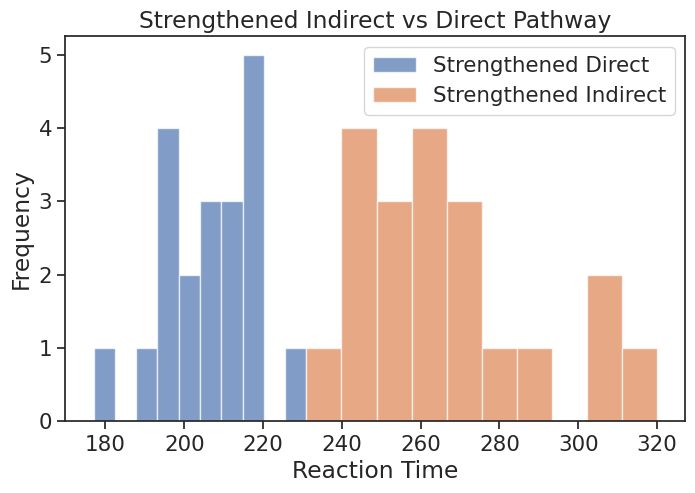

In [51]:
plt.figure(figsize=(8, 5))
plt.hist(results_bs20_ds133_is100['rt'], alpha = 0.7, label='Strengthened Direct')
plt.hist(results_bs20_ds100_is133['rt'], alpha = 0.7, label='Strengthened Indirect')

#
plt.title('Strengthened Indirect vs Direct Pathway')
plt.xlabel('Reaction Time')
plt.ylabel('Frequency')
plt.legend()

plt.show()



### Question 1.1 [6 pt]

How what does increasing the relative efficacy of the direct and indirect pathways do to the networks' decision speed? Explain why this occurs.


In [ ]:
# Write your answer here, as a python comment
# Relative to strengthening the direct pathway, strengthening the indirect pathway increases reaction times.
# This makes sense because the direct pathway represents the "go" side of decision making,
# so increasing its strength will cause the decision boundary to be reached faster on average.
# In contrast, the indirect pathway represents the "no-go" side, so the boundary will be reached more slowly on averge when it is stronger.

### Question 1.2: [6 pt]
Rerun the simulations above but increase the synaptic weight from STN to GPi from 0.0324 to 0.04. How does this influence the outcome of the simulations? Why does this happen?

(Hint: if you get an error while running the simulations, this is supposed to happen).

In [ ]:
# Write your answer here, as a python comment
# This happens because the subthalamic nucleus to globus pallidus internus pathway facilitates the "emergency break" function of the decision making process
# So increasing the synaptic weight of this connection increases the tendency to halt the decision making process resulting in no decision
# and thus no decision time or accuracy that can be put in a Pandas DataFrame.
# This will tend to effect the condition with the stronger indirect pathway more because it is already slower than the direct pathway
# Hence why the effect is different for the two conditions.

---
## Part 2 - Predator-prey dynamics [49 pt]

In this part, you will investigate how different prey behavior effects predator fitness when the predator moves actively towards the prey.

In lab 6, we saw how the predator and prey variables can effect their fitness metrics when both followed random movements. Here, we will investigate:
1. How agents with differing movement behaviors effect fitness scores when a predator can actively move towards the prey.
2. How prey would need to adapt if a superior predator is introduced.

You will instantiate a type *GreedyPredatorGrid* predator (see below and explorelib/agents.py for details), and see how prey of types *DiffusionGrid*, *LevyGrid*, and *FreezeLevyGrid* effect predator and prey survival.

Here are brief descriptions of each agent type:

Predator:
1. *GreedyPredatorGrid*: The GreedyPredatorGrid class defines an agent in 2D that, at each time step, calculates and moves greedily towards the closest other agent on the grid, with a possibility to not move based on the parameter *p_move*.

Prey:
1. *DiffusionGrid*: The agent performs a diffusion search on the grid, taking steps in random directions for lengths sampled from an exponential distribution, constrained by a minimum length and step size.
2. *LevyGrid*: The agent conducts a Levy search on the grid, moving in random directions with step lengths determined by a power-law distribution and controlled by a minimum length, step size, and exponent.
3. *FreezeLevyGrid*: The agent conducts a Levy search on the grid with a chance to freeze in place instead of turning, determined by a given probability.

Please see the *explorationlib/agents.py* file for more information.

### Coding

In the code cells below, fill in (and run) code according to the text instructions before each one. Refer to lab 6 for help.

#### Install relevant code libraries.

In [55]:
!pip install --upgrade --no-cache-dir git+https://github.com/CoAxLab/explorationlib
!pip install --upgrade git+https://github.com/MattChanTK/gym-maze.git

  Cloning https://github.com/CoAxLab/explorationlib to /tmp/pip-req-build-m1k_ar6o
  Running command git clone --filter=blob:none --quiet https://github.com/CoAxLab/explorationlib /tmp/pip-req-build-m1k_ar6o
  Resolved https://github.com/CoAxLab/explorationlib to commit 51e93ea9a3866d32202fb912bc46f7fcb18e8a17
  Preparing metadata (setup.py) ... done
  Created wheel for explorationlib: filename=explorationlib-0.0.1-py3-none-any.whl size=41443 sha256=645a6195f78ba0156ddc9ca90b214fddf8b53309e33ce6087bc8c84fd394e672
  Stored in directory: /tmp/pip-ephem-wheel-cache-dr8cb4s7/wheels/e1/c9/e7/ed754d35dbdd02514697e4cb0cc1d82b545092dc03f7cb1d13
Successfully built explorationlib
  Cloning https://github.com/MattChanTK/gym-maze.git to /tmp/pip-req-build-u0dh0cfm
  Running command git clone --filter=blob:none --quiet https://github.com/MattChanTK/gym-maze.git /tmp/pip-req-build-u0dh0cfm
  Resolved https://github.com/MattChanTK/gym-maze.git to commit 83176811b49b5538a6213520612f44fb1bc49114
  Prep

#### Import relevant modules.

In [56]:
import shutil
import glob
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import explorationlib
from explorationlib.agent import DiffusionGrid
from explorationlib.agent import LevyGrid
from explorationlib.agent import FreezeLevyGrid
from explorationlib.agent import GreedyPredatorGrid

from explorationlib.local_gym import uniform_targets
from explorationlib.local_gym import constant_values
from explorationlib.local_gym import CompetitiveGrid

from explorationlib.run import multi_experiment
from explorationlib.util import select_exp
from explorationlib.util import select_agent
from explorationlib.util import load
from explorationlib.util import save

from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_positions2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_targets2d
from explorationlib.plot import show_gif

from explorationlib import score
from explorationlib.score import num_death
# from explorationlib.score import average_reward
from explorationlib.score import total_reward
from explorationlib.score import first_reward

#### Set up pretty plots.

In [57]:
# Pretty plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

# Dev
%load_ext autoreload
%autoreload 2

---
## Part 2.1 - Prey with different behavior traits

In this part we will investigate how agents with differing movement behaviors effect fitness scores.

### 2.1.1 Investigating prey with different behaviors

First, we will investigate how three different types of prey compare against a single type of predator that moves towards the prey.

In [231]:
# Shared env params
num_steps = 50
num_experiments = 50
seed_value = 559 # DO NOT TOUCH (for consistent results across students)

# Agent parameters
# Fast
fast_scale = 5
fast_min_length = 15
fast_step_size = 15

# Flight
flight_exp = 3
flight_step_size = 11

# Freeze
p_freeze = 0.9
freeze_exp = 3
freeze_step_size = 8

# Predator
pred_step_size = 1 # predator step size
p_move = 0.9 # probability of moving at each time step
detection_radius =  1 # detection radius to kill prey

#### Complete the code below to initialize the prey input variables. Refer to Lab 6 for reference. Fast=*DiffusionGrid*, Flight=*LevyGrid*, Freeze=*FreezeLevyGrid*. The predator code is given to you. [5 pt]

In [232]:
# Define 9 prey of differing behavior types (Fast=DiffusionGrid, Flight=LevyGrid, Freeze=FreezeLevyGrid). Use the parameters above to define the agents. Refer to Lab 6 for reference.

preys = [
    [
    # Define 3 Fast Prey
    # YOUR CODE HERE
    DiffusionGrid(scale=fast_scale, min_length=fast_min_length, step_size=fast_step_size),
    DiffusionGrid(scale=fast_scale, min_length=fast_min_length, step_size=fast_step_size),
    DiffusionGrid(scale=fast_scale, min_length=fast_min_length, step_size=fast_step_size),
    ],
    [
    # Define 3 Flight Prey
    # YOUR CODE HERE
    LevyGrid(exponent=flight_exp, step_size=flight_step_size),
    LevyGrid(exponent=flight_exp, step_size=flight_step_size),
    LevyGrid(exponent=flight_exp, step_size=flight_step_size),
    ],
    [
    # Define 3 Freeze Prey
    # YOUR CODE HERE
    FreezeLevyGrid(p_freeze=p_freeze, exponent=freeze_exp,step_size=freeze_step_size),
    FreezeLevyGrid(p_freeze=p_freeze, exponent=freeze_exp,step_size=freeze_step_size),
    FreezeLevyGrid(p_freeze=p_freeze, exponent=freeze_exp,step_size=freeze_step_size),
    ]
]

# Define a new predator of type GreedyPredatorGrid (this is done for you)
pred = [
    GreedyPredatorGrid(
        step_size=pred_step_size,
        p_move=p_move,
    )
]



#### Run the experiments for each prey type (nothing to code here)

In [221]:
conditions = ['Fast', 'Flight', 'Freeze']
def run_experiments():
  '''
  Function to run experiments with defined prey & predators
  '''
  experiments = []
  model_codes = []

  for prey in preys:

    # All agents
    agents = prey + pred

    num_predators = len(pred)
    num_targets = len(prey)
    target_index = list(range(0, num_targets))
    num_agents = num_predators + num_targets

    p_target = 1
    target_boundary = (50, 50)

    # Create env
    prng = np.random.RandomState(seed_value)
    env = CompetitiveGrid(num_agents=num_agents)
    targets = uniform_targets(num_targets, target_boundary, prng=prng)
    values = constant_values(targets, 1.0)

    # Intial targets
    env.add_targets(
        target_index,
        targets,
        values,
        detection_radius=detection_radius,
        p_target=p_target,
    )

    # !
    comp_exp = multi_experiment(
        f"base",
        agents,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        seed=seed_value,
        split_state=False,
        dump=False
    )

    experiments.append(comp_exp)
    model_codes.append(0)

  return experiments, model_codes, num_agents, env

experiments, model_codes, num_agents, env = run_experiments()

base:   0%|          | 0/50 [00:00<?, ?it/s]

base:   0%|          | 0/50 [00:00<?, ?it/s]

base:   0%|          | 0/50 [00:00<?, ?it/s]

In [72]:
def print_dict_structure(d, indent=0):
    if isinstance(d, dict):
        for key, value in d.items():
            print('  ' * indent + str(key))
            print_dict_structure(value, indent + 1)
    elif isinstance(d, list):
        print('  ' * indent + "[List of length {}]".format(len(d)))
        for item in d:
            print_dict_structure(item, indent + 1)
    else:
        print('  ' * indent + str(type(d)))

#### Plot the movement behavior of the agents (nothing to code here).

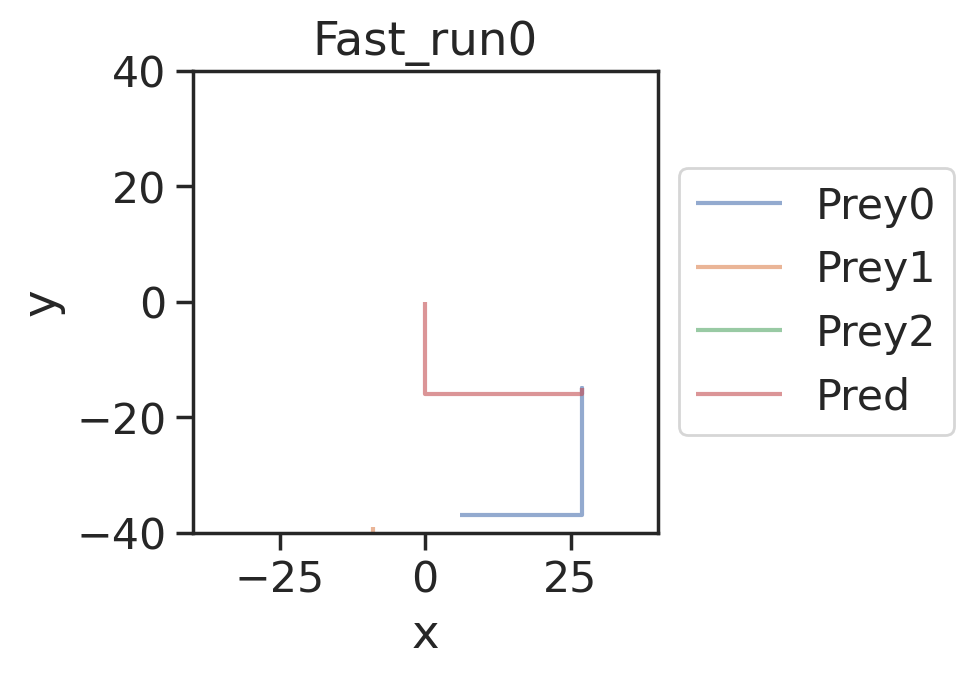

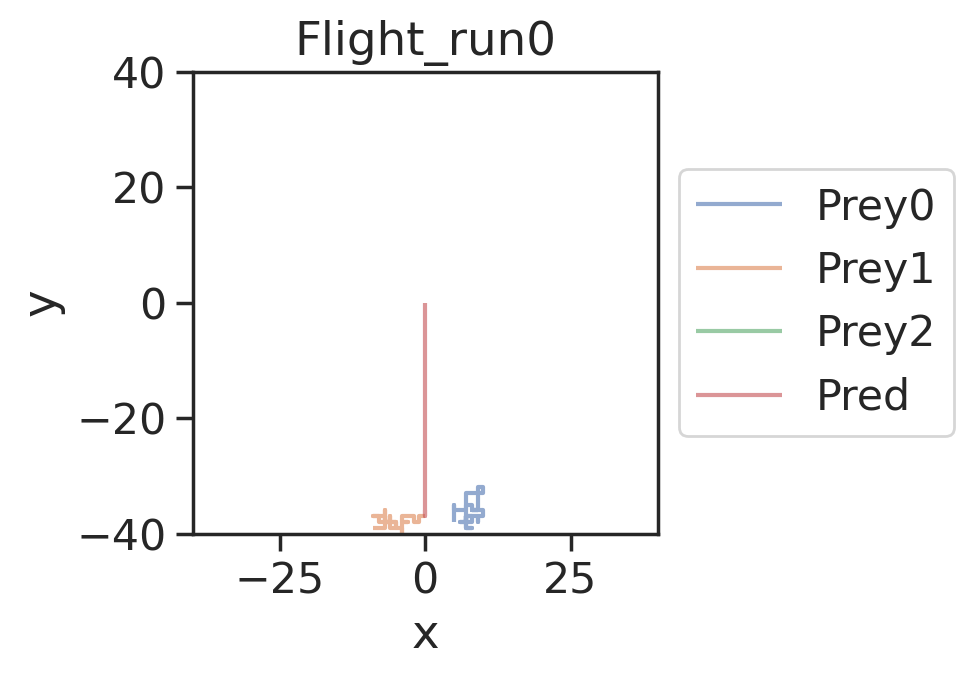

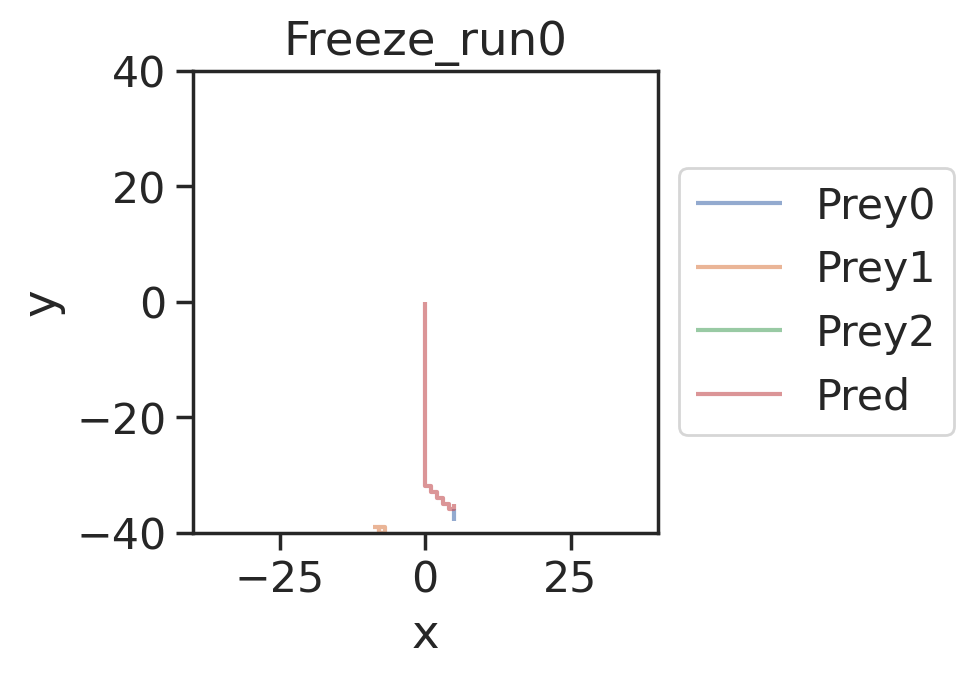

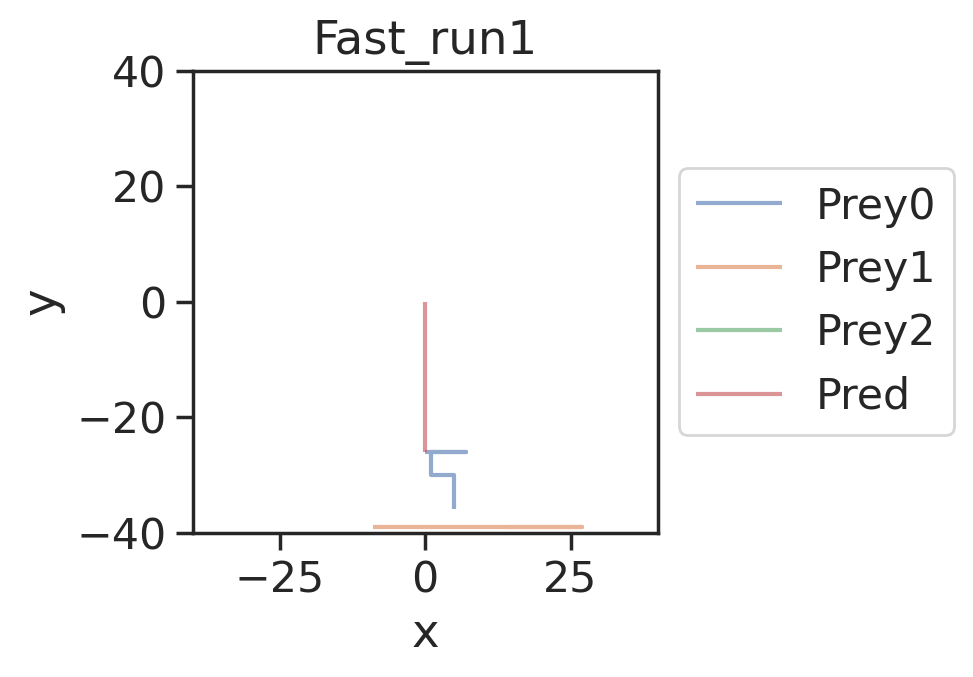

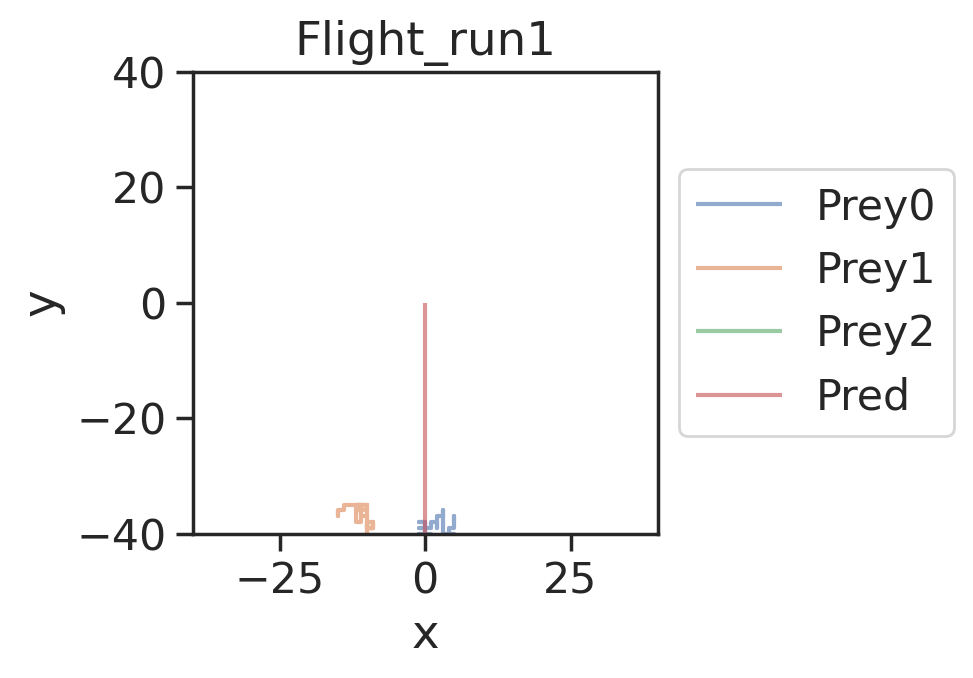

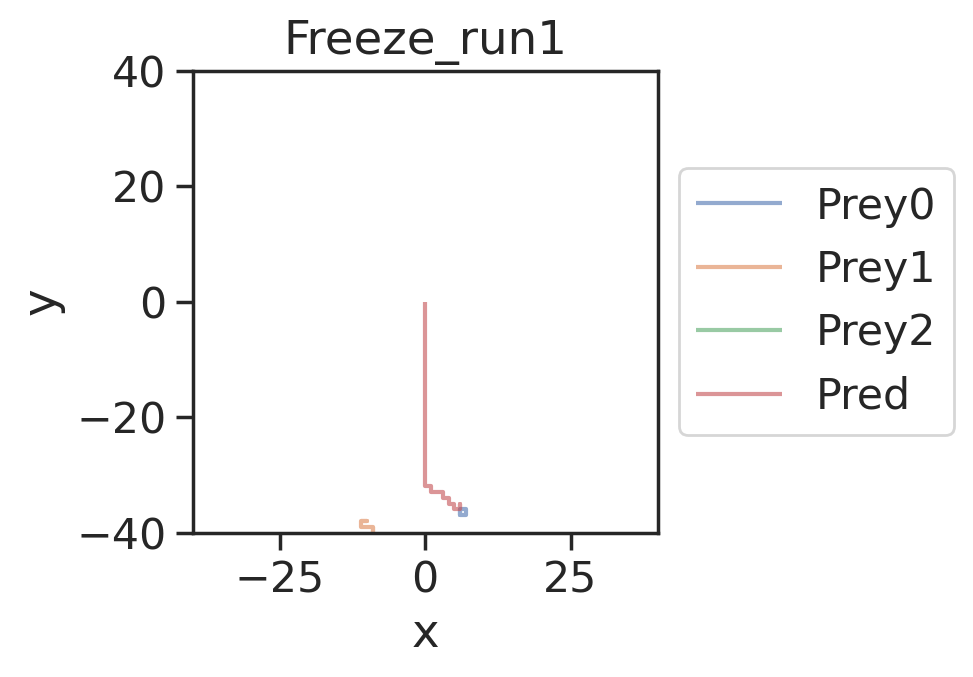

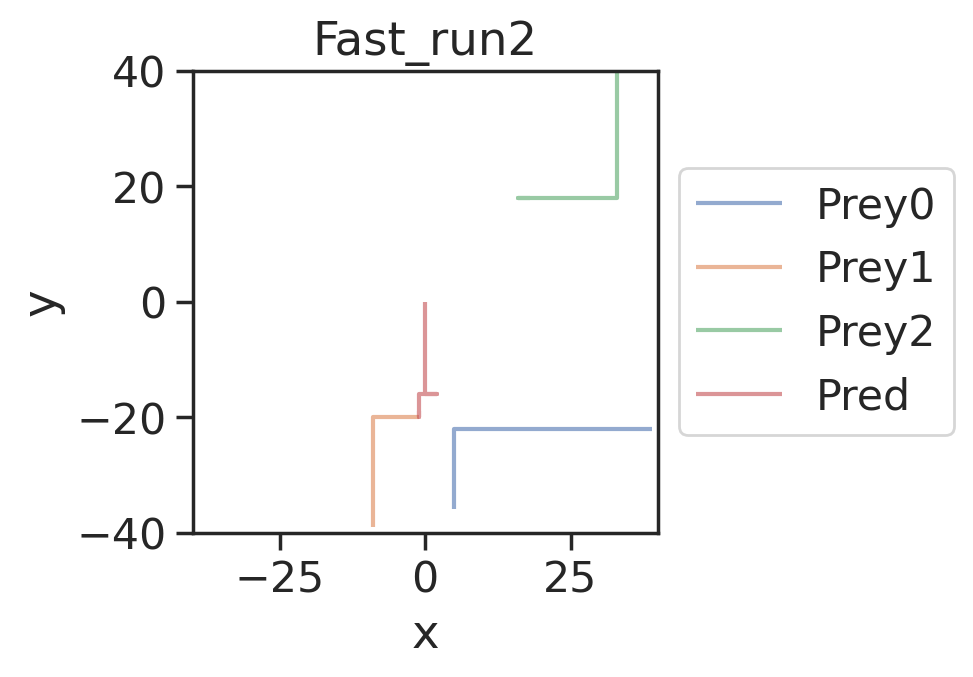

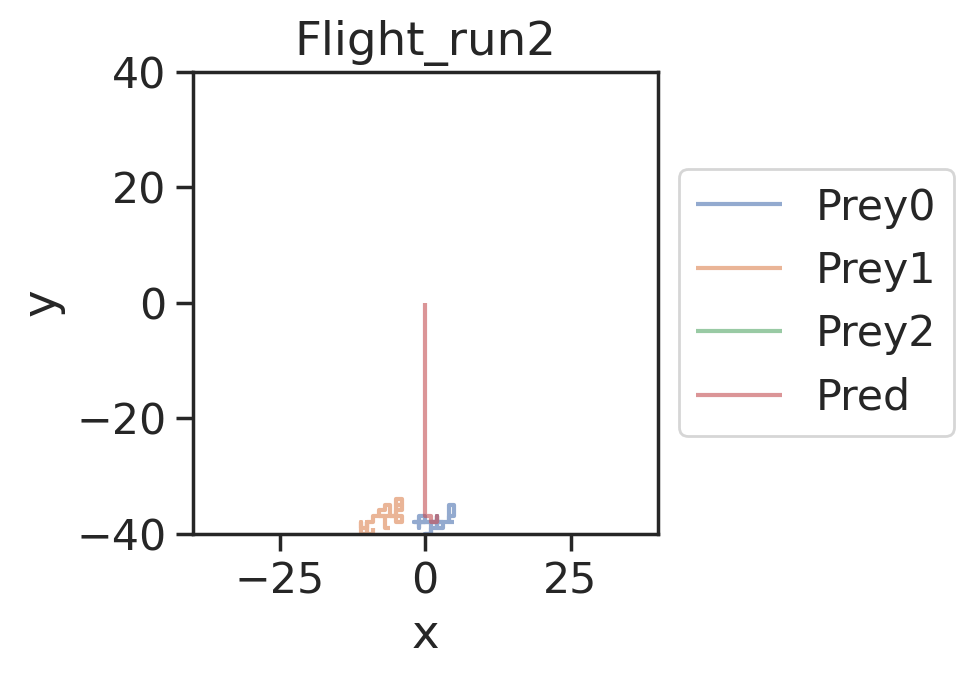

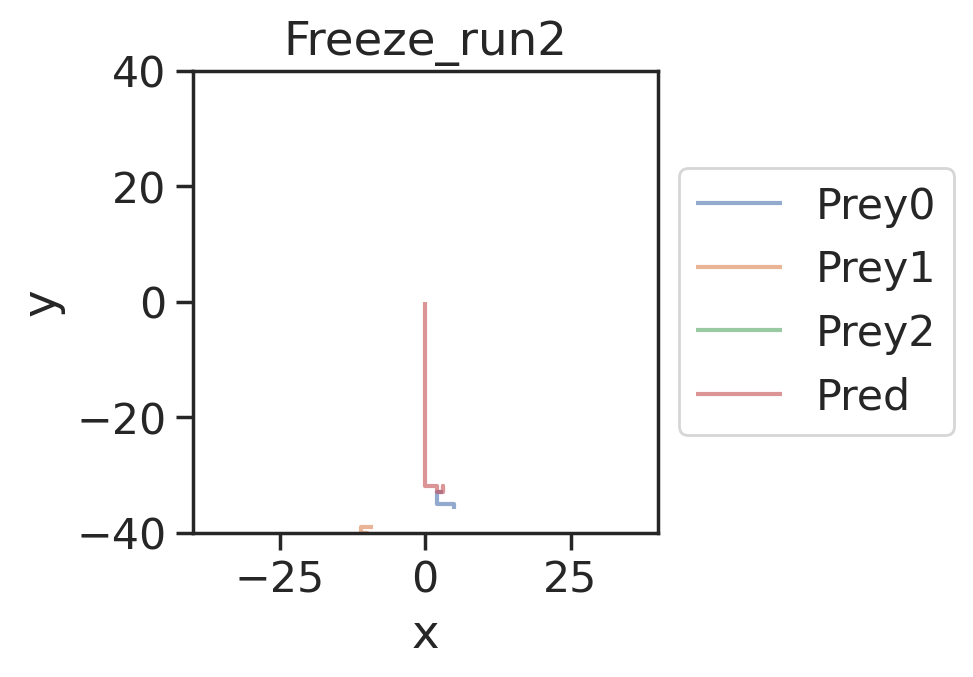

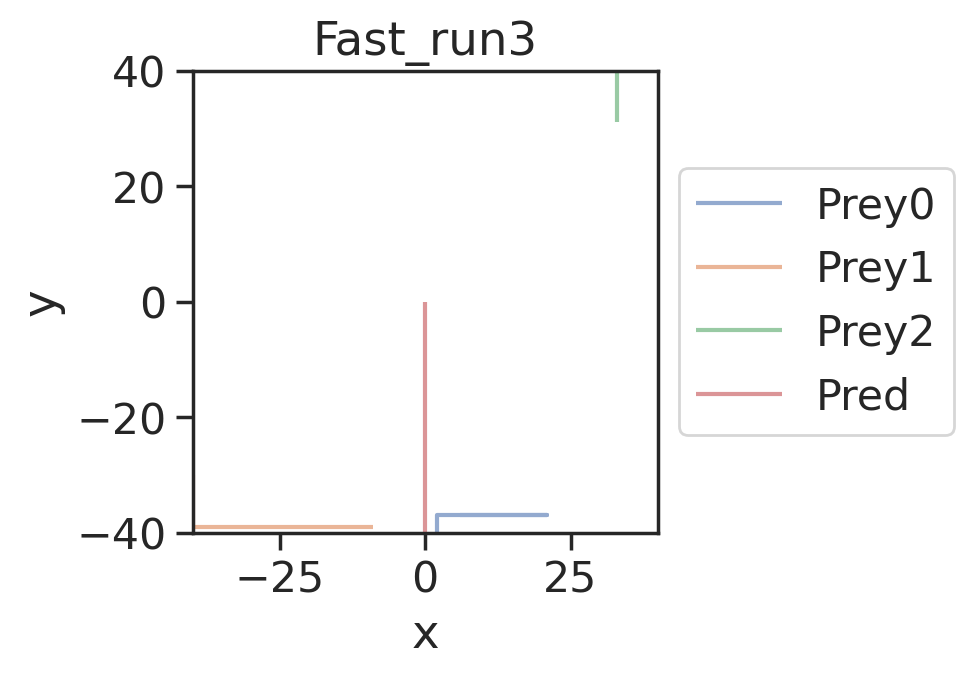

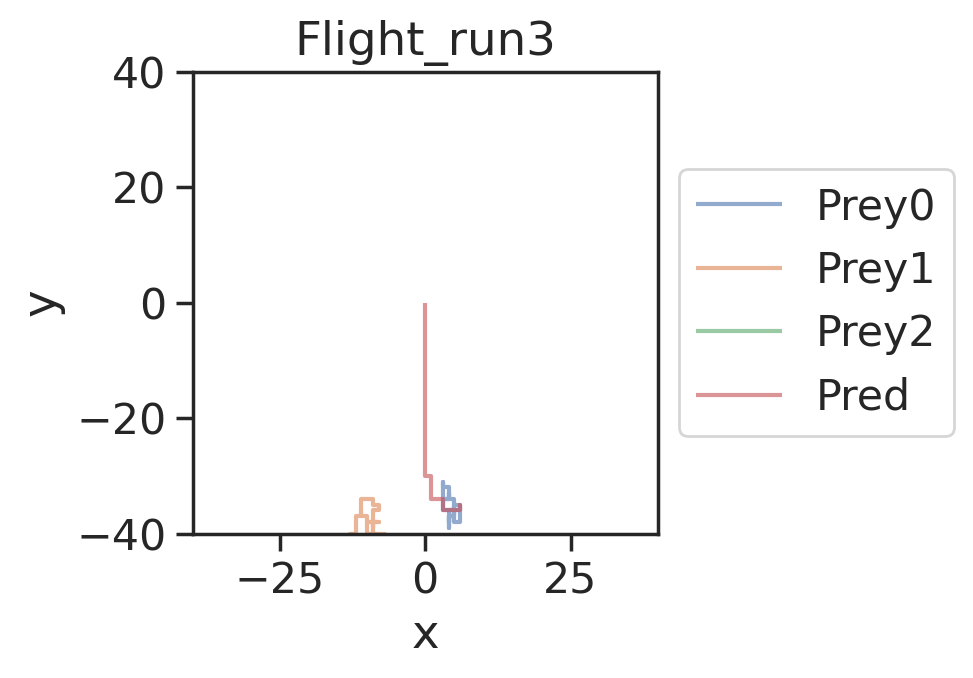

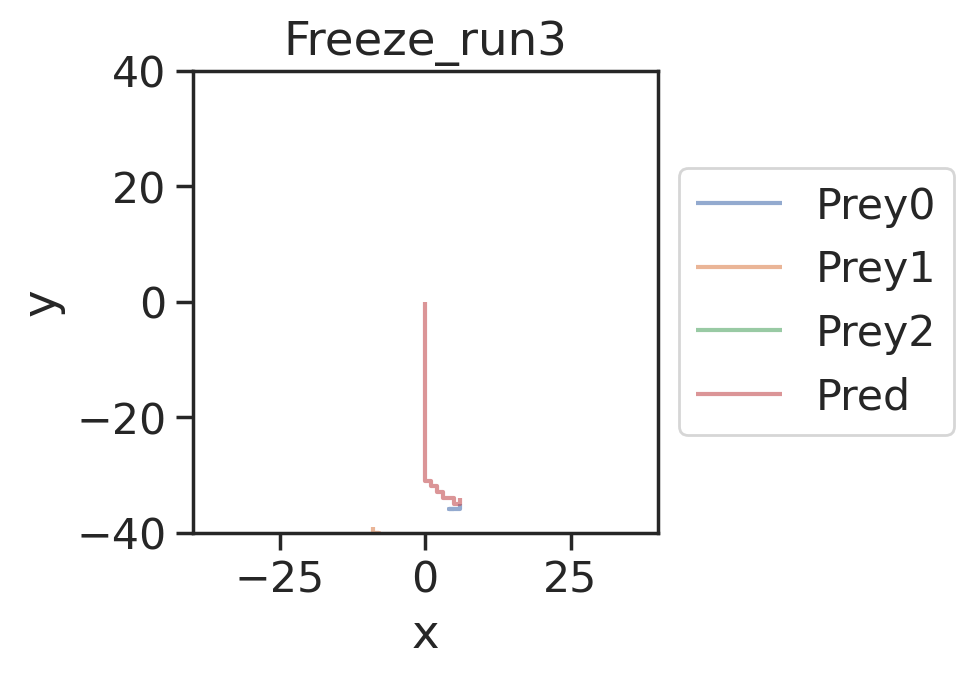

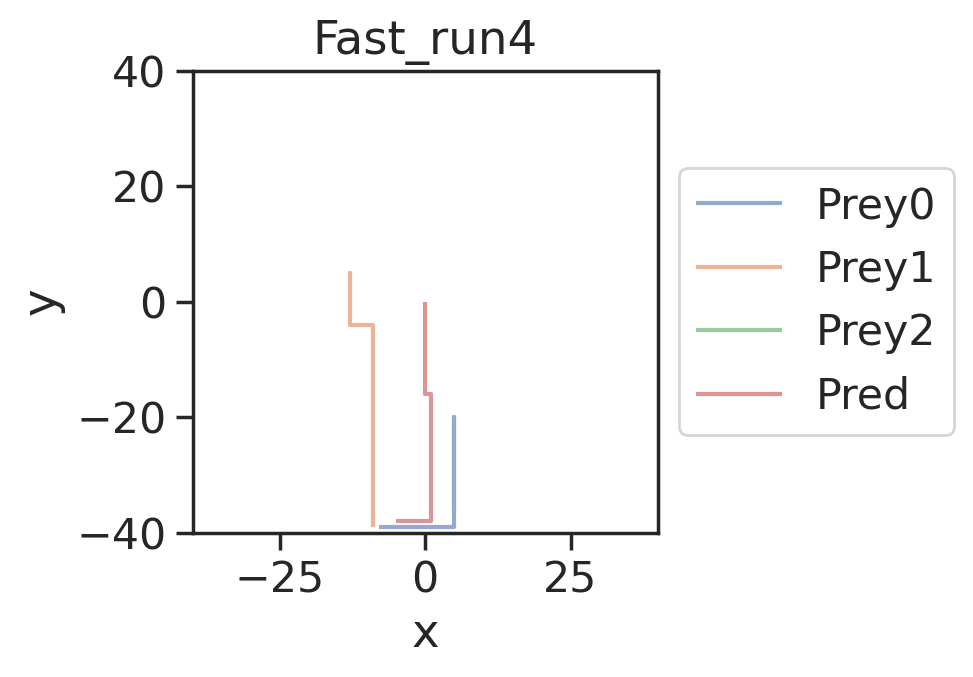

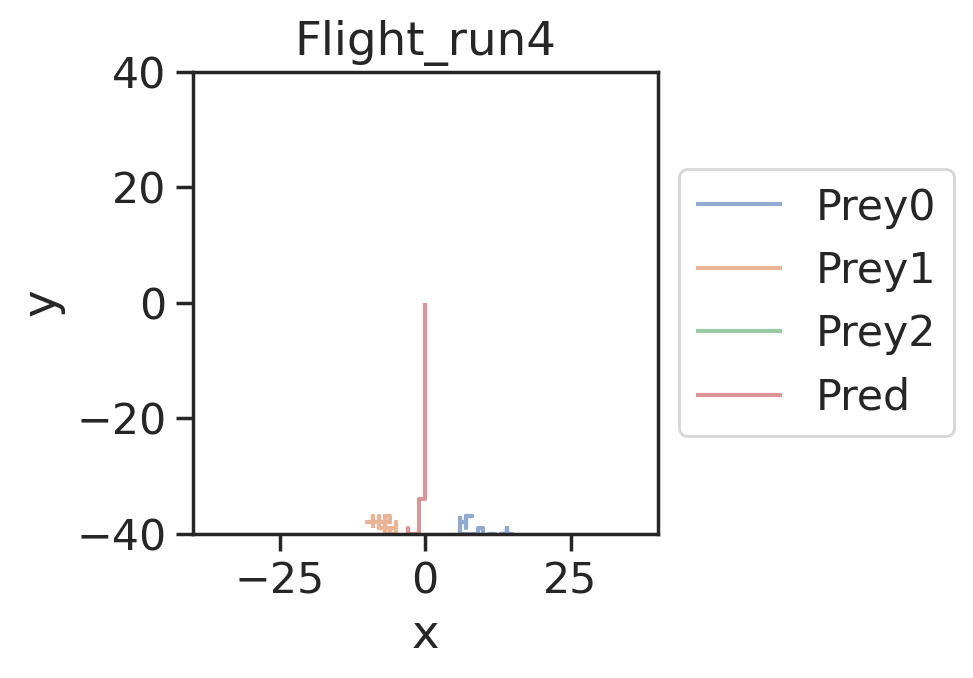

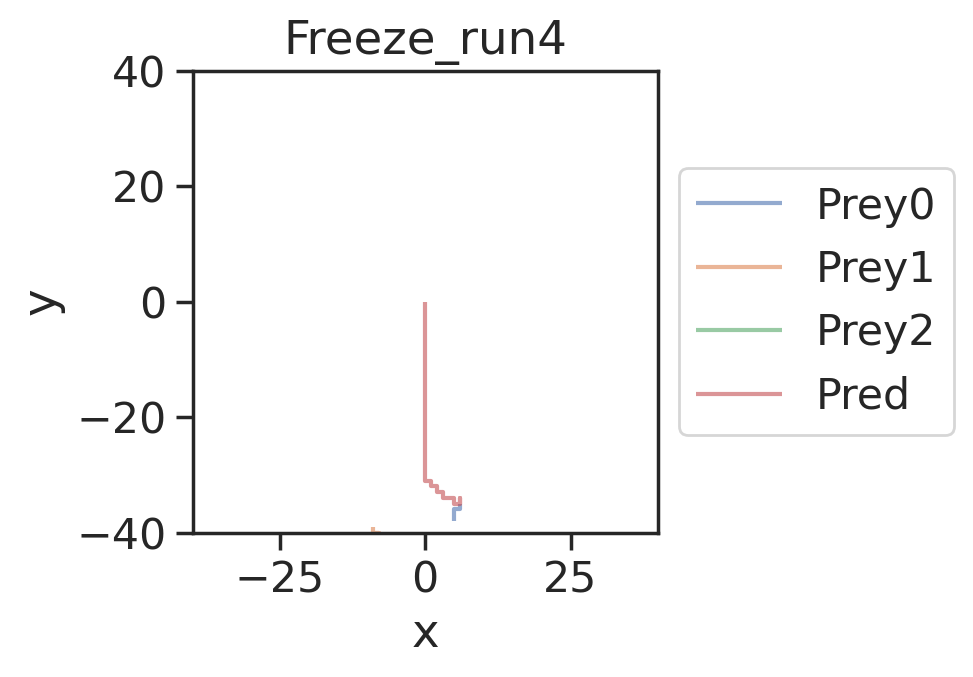

In [222]:
plot_boundary = (40, 40)
for n in range(5):
  for c_i in range(len(conditions)):
      ax = None
      ax = plot_positions2d(
          select_exp(experiments[c_i], n),
          num_agents,
          boundary=plot_boundary,
          labels=[f"Prey{n}" for n in range(3)] + ["Pred"],
          colors=None,
          alpha=0.6,
          figsize=(3, 3),
      )
      ax.set_title(f'{conditions[c_i]}_run{n}')

#### Obtain the metrics for each condition (nothing to code here).

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

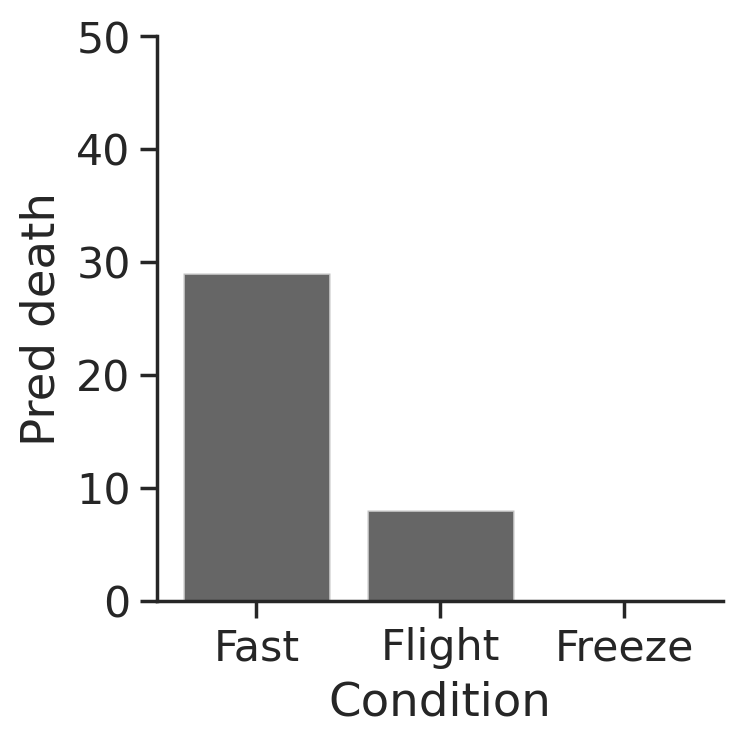

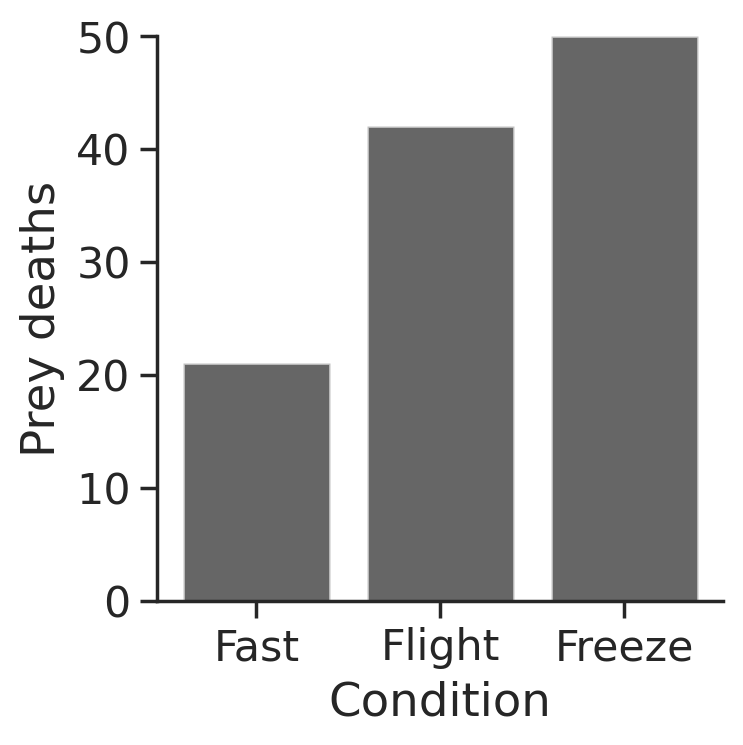

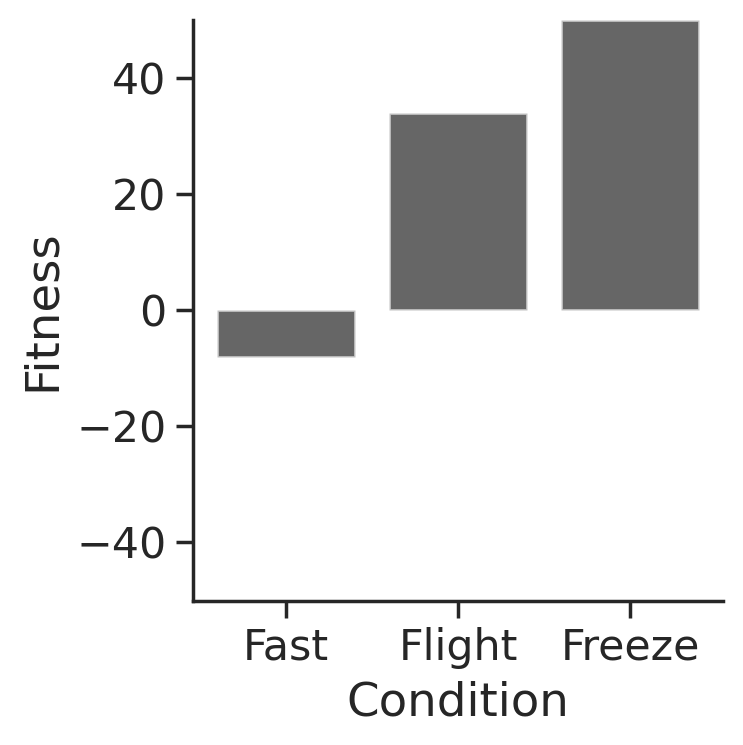

In [233]:
def plot_metrics():
  '''
  Plots predator deaths, prey deaths, and fitness under each condition
  '''
  # Est. death
  pred_scores = []
  prey_scores = []
  for i, result in zip(model_codes, experiments):
      pred_scores.append(num_death(result))
      prey_scores.append(np.sum(total_reward(result)))

  # Est. fitness
  fitness = np.asarray(prey_scores) - np.asarray(pred_scores)
  fitness = fitness.tolist()

  fig = plt.figure(figsize=(4, 4))
  plt.bar(conditions, pred_scores, color="black", alpha=0.6)
  plt.ylabel("Pred death")
  plt.xlabel("Condition")
  plt.ylim(0, num_experiments)
  plt.tight_layout()
  sns.despine()

  fig = plt.figure(figsize=(4, 4))
  plt.bar(conditions, prey_scores, color="black", alpha=0.6)
  plt.ylabel("Prey deaths")
  plt.xlabel("Condition")
  plt.ylim(0, num_experiments)
  plt.tight_layout()
  sns.despine()

  fig = plt.figure(figsize=(4, 4))
  plt.bar(conditions, fitness, color="black", alpha=0.6)
  plt.ylabel("Fitness")
  plt.xlabel("Condition")
  plt.tight_layout()
  plt.ylim(-num_experiments, num_experiments)
  sns.despine()

plot_metrics()

### Question 2.1.1 [8 pt]

What were fitness scores and prey deaths for each condition? Which prey was the most successful and why? Which prey was least successful and why? Which prey was in the middle and why? Refer to the movement behavior and metric plots in justifying your answer.

In [ ]:
# Write your answer here, as a python comment
# From most to least succesfful, there was fast, then flight, and then freeze prey.
# This is demonstrated by the same ordering in
#  - greatest to least predator deaths, indicating that critical success happens the most in that ordering of prey types
#  - least to greatest prey deaths, indicating that the ordering describes general tendencies in success
#  - least to greatest predator fitness, this metric is just a combination of the previous two and thus does not add anything new to the analysis of performance
# Because the predator goes to the closest prey, prey is most succesfull when the closest prey changes frequently.
# Since Levy flight results in more large jumps,


### Question 2.1.2 [8 pt]

The predator is of type GreedyPredatorGrid that moves towards the nearest prey at each time step. What is a different movement pattern from a predator that would likely change the relative survival ranking of the three prey types?

In [ ]:
# Write your answer here, as a python comment
# If the predator worked more "ambush style", i.e., staying in one spot, then rapidly moving towards a prey once it got sufficiently close.
# The prey would likey reverse their survival ranking as exploring more of the space would decrease survival odds
# and the fast, then flight, then freeze prey explores the most (where epxlore means moves into 'new' areas).

### Question 2.1.3 [8 pt]

How would you predict each prey type to perform if the prey and predator emitted a scent and the predator moved by moving along the positive prey scent gradient (towards the prey), and the predators moved along the negative predator scent gradient (away from the predator)? Assume the prey and predators emit the same radius and magnitude of scent, and agent parameters are the default ones defined above for all agents.

In [ ]:
# Write your answer here, as a python comment
# For the predator, the use scent gradient traversal is functionally rather similar to its current behavior.
# Thus, the main difference comes form the prey moving away from the predator isntead of moving randomly.
# The freeze prey would again do the worst because it would not be effective at "running away" from the predator
# just like it is currently.
# My guess is that the fast prey would continue to do the best because it can move faster than the flight prey
# with its larger step size, thus most effectively run from the predator.
# The main difference is it gets "locked in" to a specific direction more than the flight prey, however
# I would expect this not to overcome the advantage of faster movement.

---
## Part 2.2 - Introducing a new predator

In part 2.2, you will experiment with how the prey would need to adapt if a superior predator is introduced into an environment.

#### Define a new super predator that has the parameters (minimally) changed from the default values such that the predator has fitness >= 20 for each prey [2 pt].

base:   0%|          | 0/50 [00:00<?, ?it/s]

base:   0%|          | 0/50 [00:00<?, ?it/s]

base:   0%|          | 0/50 [00:00<?, ?it/s]

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

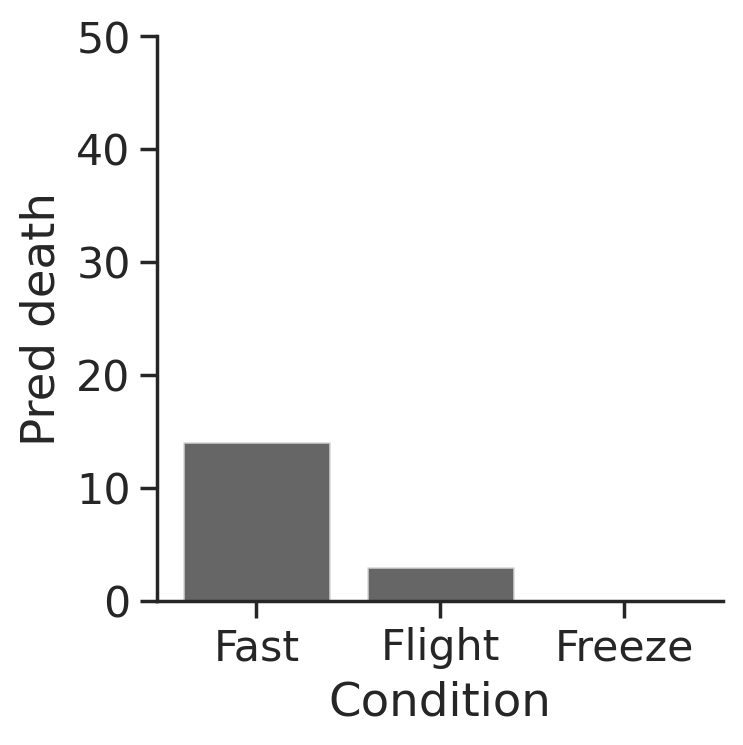

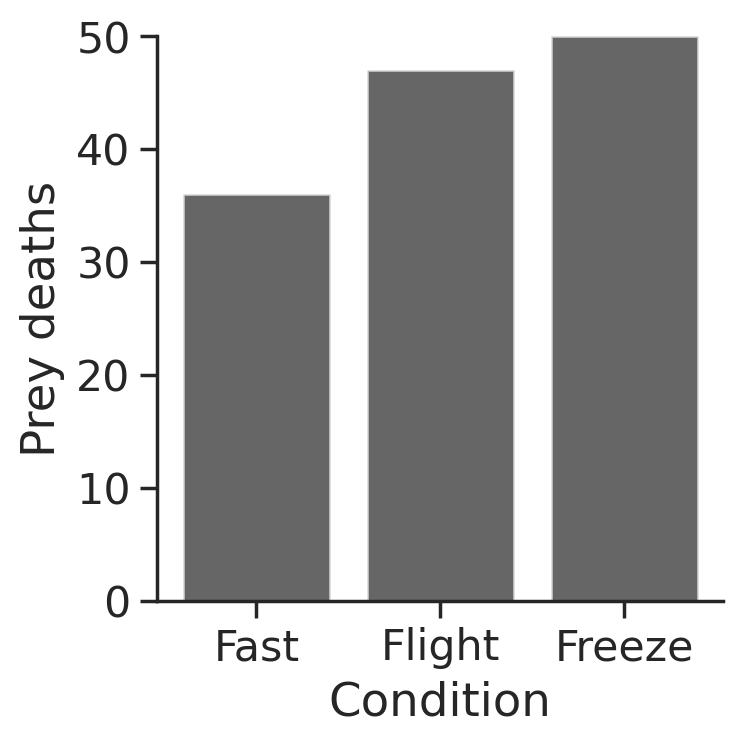

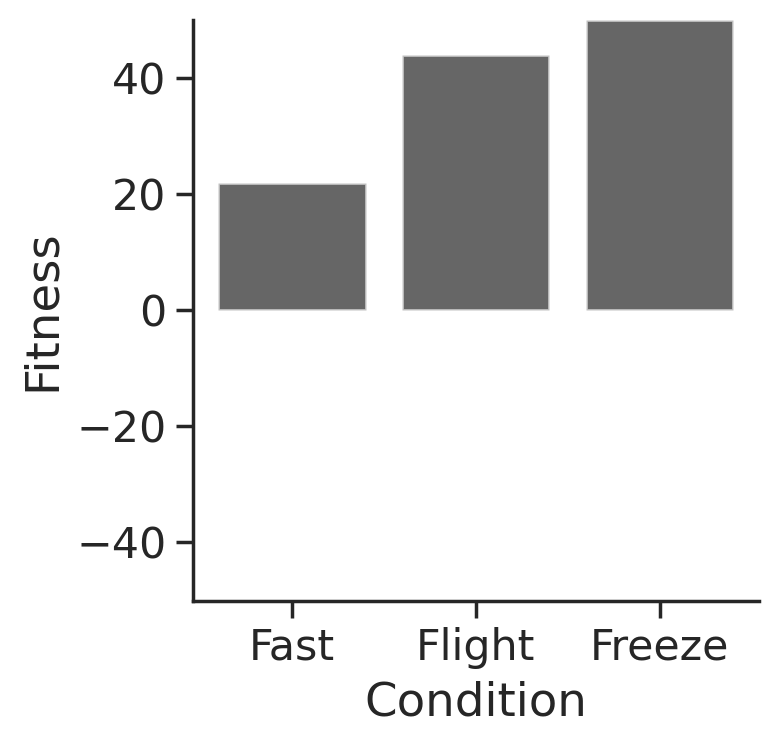

In [234]:
# Predator default parameters. Minimally change them (can be more than one if desired) to cause the predator to to have >= 20 fitness for each prey.

# CHANGE BELOW (MINIMALLY), then run this cell to check metrics
pred_step_size = 1 # predator step size
p_move = 0.9 # probability of moving at each time step
detection_radius = 5 # detection radius to kill prey

pred = [
    GreedyPredatorGrid(
        step_size=pred_step_size,
        p_move=p_move,
    )
]

experiments, model_codes, num_agents, env = run_experiments()

plot_metrics()

### Question 2.2.1 [8 pt]

What parameters did you change and why did alter the metrics? Refer to specific aspects of the predator's behavior and the metrics.

In [ ]:
# Write your answer here, as a python comment
# I changed the detection radius because changing the step_size could cause the predator to overshoot the freeze prey which often doesn't move.
# The predator will then waste time skipping back and forth over the prey as it will likely continue to be the closest to it.
# In contrast, the detection radius can only improve the predator as it will have to travel a shorter distance to reach prey,
# and prey is more likely to randomly move into its detection zone.
# This shorter distance allows the agent to perform much better agains the fast agent in particular which might have eluded the predator
# with its long paths and caused it to constantly switch focus after getting close to a new prey.

#### Mutation: define a change in one of the preys' variables (scale, min_length, step_size, p_freeze) such that it enables one of the prey types to survive the new super prey with predator fitness <= 0 for the changed prey. You should only change one parameter in one of the prey types. [2 pt]

base:   0%|          | 0/50 [00:00<?, ?it/s]

base:   0%|          | 0/50 [00:00<?, ?it/s]

base:   0%|          | 0/50 [00:00<?, ?it/s]

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

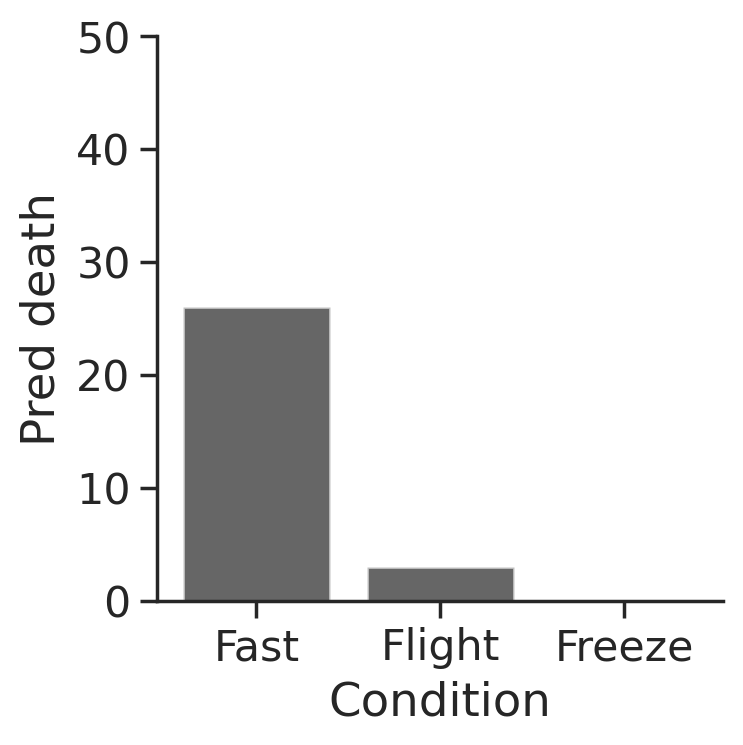

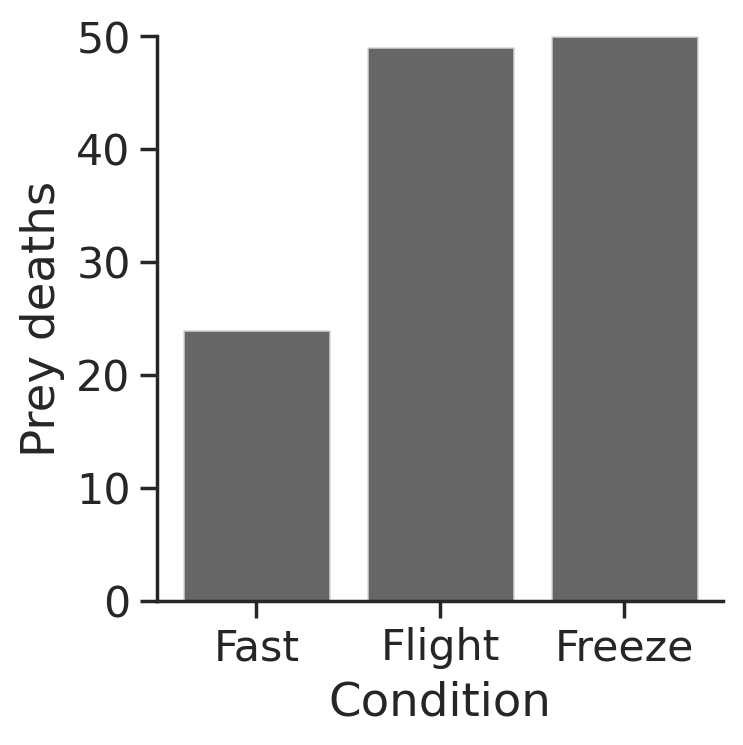

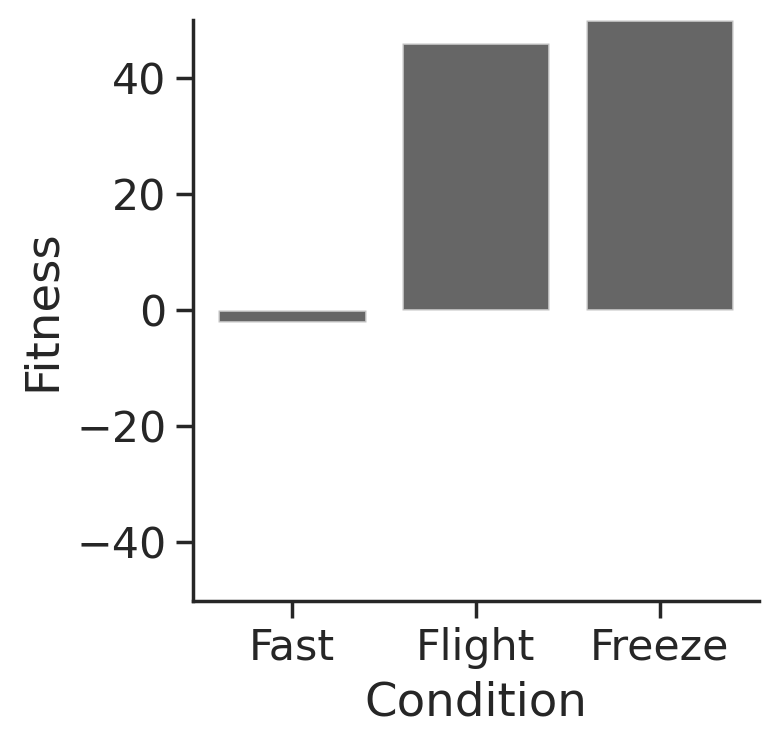

In [239]:
# Change only a single parameter here to reach fitness <=0 for one prey!

# CHANGE SINGLE PARAMETER BELOW, then run cell to check metrics
# Fast
fast_scale = 150
fast_min_length = 15
fast_step_size = 15

# Flight
flight_exp = 15
flight_step_size = 11

# Freeze
p_freeze = 0.9
freeze_exp = 3
freeze_step_size = 8

# Define the preys again (you can copy your code from 2.1)
preys = [
    [
    # Define 3 Fast Prey
    # YOUR CODE HERE
    DiffusionGrid(scale=fast_scale, min_length=fast_min_length, step_size=fast_step_size),
    DiffusionGrid(scale=fast_scale, min_length=fast_min_length, step_size=fast_step_size),
    DiffusionGrid(scale=fast_scale, min_length=fast_min_length, step_size=fast_step_size),
    ],
    [
    # Define 3 Flight Prey
    # YOUR CODE HERE
    LevyGrid(exponent=flight_exp, step_size=flight_step_size),
    LevyGrid(exponent=flight_exp, step_size=flight_step_size),
    LevyGrid(exponent=flight_exp, step_size=flight_step_size),
    ],
    [
    # Define 3 Freeze Prey
    # YOUR CODE HERE
    FreezeLevyGrid(p_freeze=p_freeze, exponent=freeze_exp,step_size=freeze_step_size),
    FreezeLevyGrid(p_freeze=p_freeze, exponent=freeze_exp,step_size=freeze_step_size),
    FreezeLevyGrid(p_freeze=p_freeze, exponent=freeze_exp,step_size=freeze_step_size),
    ]
]

experiments, model_codes, num_agents, env = run_experiments()

plot_metrics()

### Question 2.2.2 [8 pt]

Which parameter did you change, and how did it enable the prey to survive the new super predator?

In [ ]:
# Write your answer here, as a python comment
# I increased the scale parameter, which will help the fast prey survive since it will tend to sample longer movements before reconsidering its direction.
# Yet, will also sometimes sample the smaller ones unlike if the min_length parameter was changed.
# This means the prey will continue to move in a common direction for longer, making it more likley that the prey will end up (accidentally) "running away"
# from the slower predator who will be unable to catch it, while also changing direction often enough that the prey can more effectively rotate who has caught
# the predators attention.


**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here.
> *Write Name(s) here*

**DUE:** 5pm ET, Oct. 23, 2023. Email the link to the completed notebook on your Github repository to the TA and me via Canvas.